In [4]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize, Bounds
from nelson_siegel_svensson.calibrate import errorfn_ns_ols, betas_ns_ols

# Loading dataset

In [5]:
def read_files(path, filenames):
    """Reads all files and returns a dataframe"""
    return pd.concat((pd.read_csv(path + f, skipinitialspace=True) for f in filenames))

In [6]:
path_opt = "./data/raw_data/"
filenames_opt = ["spx_eod_" + str(year) + (str(month) if month >= 10 else "0" + str(month)) + ".csv" for year in range(2011, 2023) for month in range(1, 13)] + ["spx_eod_2023" + (str(month) if month >= 10 else "0" + str(month)) + ".csv" for month in range(1, 4)]
df = read_files(path_opt, filenames_opt)

In [7]:
unique_dates = df["[QUOTE_DATE]"].unique()

# Find the date that's 140 unique days before the 2011-11-01
start_date = unique_dates[unique_dates < "2011-11-01"][-140]
print(start_date)

2011-04-12


In [8]:
# Filter after between 2011-02-11 
df = df[(df["[QUOTE_DATE]"] >= "2011-11-01") & (df["[QUOTE_DATE]"] <= "2022-12-31")]

len_after_first_read = len(df)

# Cleaning raw data

In [9]:
def process_options(df_opt, call = True):
    """Cleans up column names and add time to maturity (TTM)"""
    keys = {key: key[key.find("[")+1:key.find("]")][0] + key[key.find("[")+1:key.find("]")][1:].lower() for key in df_opt.keys()}
    df_opt = df_opt.rename(columns=keys)
    pd.set_option('display.max_columns', None)

    if call:
        keys = {"C_ask": "Ask", "C_bid": "Bid"}
    else:
        keys = {"P_ask": "Ask", "P_bid": "Bid"}
    df_opt = df_opt.rename(columns=keys)
    
    df_opt["Quote_date"] = pd.to_datetime(df_opt["Quote_date"])
    df_opt["Expire_date"] = pd.to_datetime(df_opt["Expire_date"])
    # Filter out options with TTM = 0
    df_opt["TTM"] = df_opt.apply(lambda row: ((row.Expire_date - row.Quote_date).days / 365), axis = 1)
    df_opt = df_opt[df_opt["TTM"] > 0]
    df_opt["Price"] = (df_opt["Ask"] + df_opt["Bid"])/2

    columns = ["Quote_date", "Expire_date", "Price", "Underlying_last", "Strike", "TTM"]
    df_opt = df_opt[columns]
    return df_opt[columns]

In [10]:
df = process_options(df)
len_after_process = len(df)

# Print where the nan values are
print(df[df.isna().any(axis=1)])

df = df.dropna()
len_after_nan = len(df)

       Quote_date Expire_date  Price  Underlying_last  Strike       TTM
8973   2012-06-12  2012-07-06    NaN          1323.76  1335.0  0.065753
8975   2012-06-12  2012-07-06    NaN          1323.76  1345.0  0.065753
8977   2012-06-12  2012-07-06    NaN          1323.76  1355.0  0.065753
27892  2012-10-29  2012-11-02    NaN          1411.94  1100.0  0.010959
27893  2012-10-29  2012-11-02    NaN          1411.94  1125.0  0.010959
...           ...         ...    ...              ...     ...       ...
133361 2022-12-26  2023-02-10    NaN          3844.82  3540.0  0.126027
133363 2022-12-26  2023-02-10    NaN          3844.82  3560.0  0.126027
133364 2022-12-26  2023-02-10    NaN          3844.82  3570.0  0.126027
133366 2022-12-26  2023-02-10    NaN          3844.82  3580.0  0.126027
133367 2022-12-26  2023-02-10    NaN          3844.82  3590.0  0.126027

[3582 rows x 6 columns]


# Matching rates

In [57]:
def process_rates(df_r):
    """Renames rate duration"""
    # df_r date in format MM/DD/YYYY or MM/DD/YY. Handle both.
    df_r["Date"] = df_r["Date"].apply(lambda x: pd.to_datetime(x, errors='coerce', format='%m/%d/%Y') if len(x.split('/')[-1])==4 else pd.to_datetime(x, errors='coerce', format='%m/%d/%y'))
    # Rename the Date to Quote_date in both dataframes
    df_r = df_r.rename(columns={"Date": "Quote_date"})
    df_r = df_r.rename(columns={"1 Mo": 0.08333333333333333, "3 Mo": 0.25, "6 Mo": 0.5, "1 Yr": 1, "2 Yr": 2})
    # Filter df_r to after 2010-01-01
    df_r = df_r[df_r["Quote_date"] >= "2010-01-01"]
    # Only keep the renamed columns
    df_r = df_r[["Quote_date", 0.08333333333333333, 0.25, 0.5, 1, 2]]
    return df_r

def combine_opt_rates(df_opt, df_r):
    df_opt = pd.merge(df_opt, df_r, on="Quote_date", how="left")
    rates = list(df_r.columns)
    rates.remove("Quote_date")
    df_opt = df_opt.ffill()

    # Apply Nelson Siegel Svensson model for interpolation of rates and matching of TTM
    df_opt = df_opt.dropna()
    groups = df_opt.groupby("Quote_date")
    # Create an empty DataFrame to store the modified groups
    df_opt_modified = pd.DataFrame()

    num_linear = 0
    linear_groups = []
    for _, group in groups:
        # Convert TTM to years
        yield_maturities = np.array([x for x in rates])
        yields = np.array(group[rates].values.tolist()[1])
        try:
            # Calibrate with bounds on tau
            tau0 = 1.0
            bounds = Bounds([0.1], [100])
            opt_res = minimize(errorfn_ns_ols, x0=tau0, args=(yield_maturities, yields), bounds=bounds)
            
            if opt_res.success:
                curve, _ = betas_ns_ols(opt_res.x[0], yield_maturities, yields)
                group["R"] = group["TTM"].apply(lambda x: curve(x))

                # If TTM < 1/12 then use the 1 month rate
                group["R"] = group.apply(lambda row: row[0.08333333333333333] if row["TTM"] < 1/12 else row["R"], axis = 1)

                # Append the modified group to the df_opt_modified DataFrame
                df_opt_modified = pd.concat([df_opt_modified, group], ignore_index=True)
            else:
                print(f"Optimization failed for {group['Quote_date'].unique()[0]}, so using linear interpolation instead")
                yield_maturities = np.array([x for x in rates])
                # Print yield_maturities with all decimals
                np.set_printoptions(formatter={'float': lambda x: "{0:0.15f}".format(x)})
                yields = np.array(group[rates].values.tolist()[1])

                # Linear interpolation for all points
                curve = np.interp(group["TTM"], yield_maturities, yields)
                group["R"] = curve

                # If TTM < 1/12 then use the 1 month rate
                one_month_rate = group[0.08333333333333333].values[0]
                group["R"] = group.apply(lambda row: one_month_rate if row["TTM"] < 1/12 else row["R"], axis = 1)

                df_opt_modified = pd.concat([df_opt_modified, group], ignore_index=True)
                num_linear += 1
                linear_groups.append(group["Quote_date"].values[0])
        except Exception as e:
            print(f"None of the interpolations worked {group['Quote_date'].values[0]}: {e}")

    print(f"Using linear intercept on {num_linear} option groups")
    print("These are: ", linear_groups)


    df_opt_modified = df_opt_modified.ffill()
    df_opt_len_before = len(df_opt_modified)
    df_opt_modified = df_opt_modified.dropna()
    df_opt_len_after = len(df_opt_modified)
    return df_opt_modified.dropna()

In [58]:
df_r = pd.concat((pd.read_csv("./data/raw_data/" + f, skipinitialspace=True) for f in ["daily-treasury-rates.csv", "daily-treasury-rates_2023.csv", "yield-curve-rates-1990-2021.csv"]))
df_r = process_rates(df_r)

len_before_dfr = len(df_r)
df_r = df_r.dropna()
len_after_rates_dropes_nan = len(df_r)

df = combine_opt_rates(df, df_r)
len_after_rate_matching = len(df)

Optimization failed for 2016-10-07 00:00:00, so using linear interpolation instead
Optimization failed for 2016-10-10 00:00:00, so using linear interpolation instead
Optimization failed for 2019-07-10 00:00:00, so using linear interpolation instead
Using linear intercept on 3 option groups
These are:  [numpy.datetime64('2016-10-07T00:00:00.000000000'), numpy.datetime64('2016-10-10T00:00:00.000000000'), numpy.datetime64('2019-07-10T00:00:00.000000000')]


# Filtering

In [59]:
# Filter out options with TTM < 2 years
df = df[df["TTM"] <= 2]
len_after_ttm = len(df)

# Filter moneyness
df["Moneyness"] = df['Underlying_last'] / df["Strike"]

df = df[(df['Moneyness'] >= 0.8) & (df['Moneyness'] <= 2)]
len_after_moneyness = len(df)

df["R"] = df["R"].apply(lambda x: x / 100)

## Analysing lost data

In [60]:
print("Starting with " + str(len_after_first_read) + " rows, and ended up with " + str(len_after_moneyness) + " rows")
print("Dropped " + str(len_after_first_read - len_after_moneyness) + " rows in total")
print("Which is " + str(round((len_after_first_read - len_after_moneyness)/len_after_first_read*100, 2)) + "%")
print("Dropped ", len_after_first_read - len_after_process, " rows due to filtering TTM = 0")
print("Dropped ", len_after_process - len_after_nan, " rows due removing NaN in option data")
print("Dropped ", len_after_nan - len_after_rate_matching, " rows during matching options with rates")
print("Dropped ", len_after_rate_matching - len_after_ttm, " rows due to filtering TTM < 2 years")
print("Dropped ", len_after_ttm - len_after_moneyness, " rows due to filtering moneyness")

Starting with 13108756 rows, and ended up with 11328707 rows
Dropped 1780049 rows in total
Which is 13.58%
Dropped  249566  rows due to filtering TTM = 0
Dropped  3582  rows due removing NaN in option data
Dropped  0  rows during matching options with rates
Dropped  285293  rows due to filtering TTM < 2 years
Dropped  1241608  rows due to filtering moneyness


In [61]:
# Only keep Quote_date	Price	Underlying_last	Strike	TTM R
df = df[["Quote_date", "Price", "Underlying_last", "Strike", "TTM", "R"]]

In [3]:
print(13108756-3582-249566-285293-1241608)

11328707


## Read to file

In [62]:
df.to_csv("./data/processed_data/2023-06-07_data for analysis_v2.csv")

## Analysis

In [63]:
print(df["Quote_date"].min())
print(df["Quote_date"].max())

print("Num unique days before: ", len(df["Quote_date"].unique()), " and after: ", len(df["Quote_date"].unique()))


2011-11-01 00:00:00
2022-12-30 00:00:00
Num unique days before:  2796  and after:  2796


In [64]:
display(df[df["Quote_date"]=="2019-07-10"])

,Quote_date,Price,Underlying_last,Strike,TTM,R
6353993,2019-07-10,1492.190,2993.01,1500.0,0.005479,0.021800
6353994,2019-07-10,1442.200,2993.01,1550.0,0.005479,0.021800
6353995,2019-07-10,1392.705,2993.01,1600.0,0.005479,0.021800
6353996,2019-07-10,1342.155,2993.01,1650.0,0.005479,0.021800
6353997,2019-07-10,1292.205,2993.01,1700.0,0.005479,0.021800
...,...,...,...,...,...,...
6359577,2019-07-10,97.295,2993.01,3350.0,1.942466,0.018263
6359578,2019-07-10,82.145,2993.01,3400.0,1.942466,0.018263
6359579,2019-07-10,57.800,2993.01,3500.0,1.942466,0.018263
6359580,2019-07-10,40.150,2993.01,3600.0,1.942466,0.018263


/var/folders/wk/x86_p6511l95p594k6qnb98h0000gn/T/ipykernel_3527/1223687586.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sample["R"] = df_sample["R"] * 100
/var/folders/wk/x86_p6511l95p594k6qnb98h0000gn/T/ipykernel_3527/1223687586.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sample["Quote_date"] = pd.to_datetime(df_sample["Quote_date"], format="%Y-%m-%d")


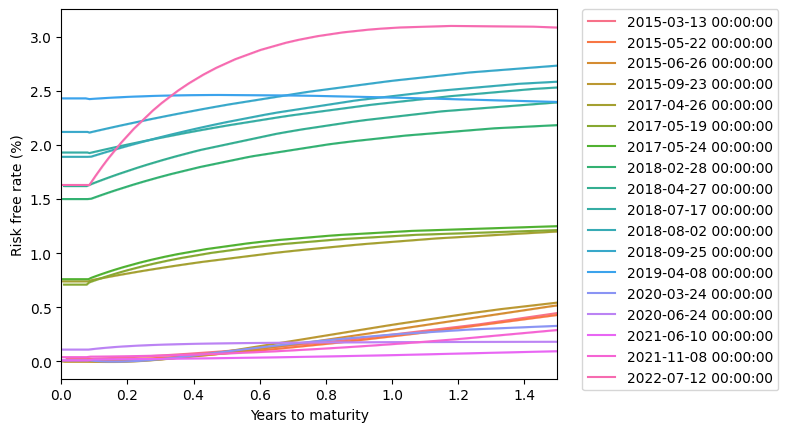

In [65]:
# Import seaborn
import seaborn as sns
import matplotlib.pyplot as plt

# Filter the dataframe from 60 random dates
df_sample = df[df["Quote_date"] >= "2015-01-01"]
dates = df_sample["Quote_date"].unique()
dates = np.random.choice(dates, 18, replace=False)
df_sample = df[df["Quote_date"].isin(dates)]
df_sample["R"] = df_sample["R"] * 100


# Turn Quote_date into a datetime object with yyyy-mm-dd format
df_sample["Quote_date"] = pd.to_datetime(df_sample["Quote_date"], format="%Y-%m-%d")

# Plot 60 line chart for R with respect to TTM by having Quote_date as hue
sns.lineplot(data=df_sample, x="TTM", y="R", hue="Quote_date")
plt.xlabel("Years to maturity")
plt.ylabel("Risk free rate (%)")

# Also plot the line for 2019-07-10
#ns.lineplot(data=df[df["Quote_date"]=="2019-07-10"], x="TTM", y="R", color="black")

# Make the legend be outside of the graph
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlim(0, 1.5)

# vertical lines for 1 month,  3 month,  6 month, 1 year and 2 year
#plt.axvline(x=0.08333333333333333, color='black', linestyle='--')
#plt.axvline(x=0.25, color='black', linestyle='--')
#plt.axvline(x=0.5, color='black', linestyle='--')
#plt.axvline(x=1, color='black', linestyle='--')
#plt.axvline(x=2, color='black', linestyle='--')

plt.show()